Фабула: нам предоставили логи компьютерной игры "Космические братья" и данные о проплаченной рекламе. Нам нужно оценить рентабельность рекламных источников и поведение игроков в игре, чтобы дать рекомендации по рекламному каналу.

In [1]:
#загрузим библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [2]:
#загрузим датасеты

actions = pd.read_csv('/datasets/game_actions.csv')
costs = pd.read_csv('/datasets/ad_costs.csv')
source = pd.read_csv('/datasets/user_source.csv')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
#посмотрим ближе на данные

display(actions.head(),
        actions.shape,
        actions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


(135640, 5)

None

In [5]:
display(costs.head(),
        costs.shape,
        costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


(28, 3)

None

In [6]:
display(source.head(),
        source.shape,
        source.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


(13576, 2)

None

Временные данные нужно перевести во временной формат, остальные данные соответствуют типам.

In [7]:
#переведем данные о времени во временной формат и сразу выделим отдельно дату в датасете с действиями игроков

actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])
costs['day'] = pd.to_datetime(costs['day'])

In [8]:
#проверим датасеты на наличие дубликатов

actions.duplicated().sum()

1

In [9]:
costs.duplicated().sum()

0

In [10]:
source.duplicated().sum()

0

Много дубликатов в датасете с действиями игроков. Игроки могут совершть повторяющиеся действия при прохождении уровня, поэтому не вижу необходимости эти дубликаты убирать.

В датасете с действиями игроков имеются пропуски в столбце с типом зданий и типом проекта. Как-то их заполнять тоже не вижу необходимости, вот причины:

1. не все игроки строят все три типа зданий;
2. не все игроки завершают уровень черех исследование, а победа без исследования у нас никак в данных не маркировалась. Значит, велика вероятность, что пропуски в столбце с типом проекта обозначают игроков, поторые прошли уровень через победу над противником или перестали играть, не завершив уровень.

In [11]:
#посмотрим, какие значения есть в наших данных об игровых событиях

actions['event'].value_counts()

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

Первый уровень завершили 5817 игроков. 1866 завершили проект по сборке спутников, но не факт, что перешли на следующий уровень.

Постройка чаще всего встречается среди событий потому, что каждый игрок строит несколько зданий, а не одно.

In [12]:
#посмотрим, какие рекламные источники использовались

costs['source'].value_counts()

youtube_channel_reklama    7
yandex_direct              7
facebook_ads               7
instagram_new_adverts      7
Name: source, dtype: int64

Реклама закупалась на 4 источниках: Facebook, Instagram, Yandex, Youtube. Рекламный трафик распределен равномерно по каналам. 

In [13]:
#посмотрим, какие временные рамки охватывают данные, и как распределяется активность игроков

actions['event_datetime'].min()

Timestamp('2020-05-04 00:00:01')

In [14]:
actions['event_datetime'].max()

Timestamp('2020-06-05 12:32:49')

In [15]:
#выделим информацию о дате без времени

actions['day'] = actions['event_datetime'].dt.date

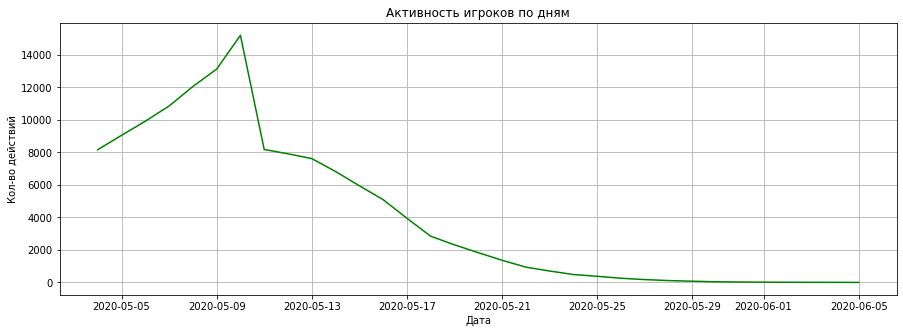

In [16]:
#построим график активности игроков

actions.groupby('day')['event'].count().plot(grid=True, figsize=(15,5), color='g')
plt.title('Активность игроков по дням')
plt.xlabel('Дата')
plt.ylabel('Кол-во действий')
plt.show()

На майских выходных активность выше всего, затем она снижается. До конца рассматриваемого периода дошло очень мало игроков.

In [17]:
actions1 = pd.get_dummies(actions, columns=['building_type'])

In [18]:
actions1 = pd.get_dummies(actions1, columns=['event'])

In [19]:
actions1 = pd.get_dummies(actions1, columns=['project_type'])
actions1.head()

,event_datetime,user_id,day,building_type_assembly_shop,building_type_research_center,building_type_spaceport,event_building,event_finished_stage_1,event_project,project_type_satellite_orbital_assembly
0,2020-05-04 00:00:01,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04,1,0,0,1,0,0,0
1,2020-05-04 00:00:03,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04,1,0,0,1,0,0,0
2,2020-05-04 00:00:16,6edd42cc-e753-4ff6-a947-2107cd560710,2020-05-04,1,0,0,1,0,0,0
3,2020-05-04 00:00:16,92c69003-d60a-444a-827f-8cc51bf6bf4c,2020-05-04,1,0,0,1,0,0,0
4,2020-05-04 00:00:35,cdc6bb92-0ccb-4490-9866-ef142f09139d,2020-05-04,1,0,0,1,0,0,0


# 1.2 Вывод 

Мы завершили исследовательский анализ данных. На вход поступили 3 датасета с информацией об игроках, их действиях, рекламных источниках и затратах.

Данные были преобразованы к нужным типам. Пропуски и дубликаты в таблице с логами игры было решено не трогать, т.к. в данном контексте они могут нести дополнительную информацию. 

# 2.1 Расчет рентабельности рекламных источников

In [20]:
#сформируем профили пользователей

profiles = actions1.sort_values(by=['user_id', 'event_datetime']).groupby('user_id').agg({'event_datetime':['first', 'last'], 'building_type_assembly_shop':'sum', 'building_type_research_center':'sum', 'building_type_spaceport':'sum', 'event_building':'sum', 'event_finished_stage_1':'sum', 'event_project':'sum', 'project_type_satellite_orbital_assembly':'sum'})

In [21]:
profiles.head()

event_datetime                      \
                                                   first                last   
user_id                                                                        
0001f83c-c6ac-4621-b7f0-8a28b283ac30 2020-05-06 01:07:37 2020-05-20 11:26:06   
00151b4f-ba38-44a8-a650-d7cf130a0105 2020-05-06 03:09:12 2020-05-18 10:46:52   
001aaea6-3d14-43f1-8ca8-7f48820f17aa 2020-05-05 18:08:52 2020-05-14 09:21:27   
001d39dc-366c-4021-9604-6a3b9ff01e25 2020-05-05 21:02:05 2020-05-12 07:40:47   
002f508f-67b6-479f-814b-b05f00d4e995 2020-05-05 13:49:58 2020-05-22 02:46:45   

                                     building_type_assembly_shop  \
                                                             sum   
user_id                                                            
0001f83c-c6ac-4621-b7f0-8a28b283ac30                           6   
00151b4f-ba38-44a8-a650-d7cf130a0105                           4   
001aaea6-3d14-43f1-8ca8-7f48820f17aa                           2   
001d39dc-366c-4021-9604-6a3b9ff01e25                           4   
002f508f-67b6-479f-814b-b05f00d4e995                           3   

                                     building_type_research_center  \
                                                               sum   
user_id                                                              
0001f83c-c6ac-4621-b7f0-8a28b283ac30                             1   
00151b4f-ba38-44a8-a650-d7cf130a0105                             0   
001aaea6-3d14-43f1-8ca8-7f48820f17aa                             0   
001d39dc-366c-4021-9604-6a3b9ff01e25                             0   
002f508f-67b6-479f-814b-b05f00d4e995                             1   

                                     building_type_spaceport event_building  \
                                                         sum            sum   
user_id                                                                       
0001f83c-c6ac-4621-b7f0-8a28b283ac30                       6             13   
00151b4f-ba38-44a8-a650-d7cf130a0105                       5              9   
001aaea6-3d14-43f1-8ca8-7f48820f17aa                       2              4   
001d39dc-366c-4021-9604-6a3b9ff01e25                       4              8   
002f508f-67b6-479f-814b-b05f00d4e995                       8             12   

                                     event_finished_stage_1 event_project  \
                                                        sum           sum   
user_id                                                                     
0001f83c-c6ac-4621-b7f0-8a28b283ac30                      0             0   
00151b4f-ba38-44a8-a650-d7cf130a0105                      0             0   
001aaea6-3d14-43f1-8ca8-7f48820f17aa                      0             0   
001d39dc-366c-4021-9604-6a3b9ff01e25                      1             0   
002f508f-67b6-479f-814b-b05f00d4e995                      0             0   

                                     project_type_satellite_orbital_assembly  
                                                                         sum  
user_id                                                                       
0001f83c-c6ac-4621-b7f0-8a28b283ac30                                       0  
00151b4f-ba38-44a8-a650-d7cf130a0105                                       0  
001aaea6-3d14-43f1-8ca8-7f48820f17aa                                       0  
001d39dc-366c-4021-9604-6a3b9ff01e25                                       0  
002f508f-67b6-479f-814b-b05f00d4e995                                       0

In [22]:
profiles.columns = profiles.columns.map(lambda x: x[1]) 
profiles = profiles.reset_index()

In [23]:
#выделим отдельно день из полной даты-времени

profiles['start_day'] = profiles['first'].dt.date
profiles['end_day'] = profiles['last'].dt.date
profiles['start_day'] = pd.to_datetime(profiles['start_day'])
profiles['end_day'] = pd.to_datetime(profiles['end_day'])

In [24]:
profiles.columns = ['user_id', 'first', 'last', 'assembly_shop', 'research_center', 'spaceport', 'building', 'finished_stage_1', 'project', 'satellite_orbital_assembly', 'start_day', 'end_day']
profiles.head()

,user_id,first,last,assembly_shop,research_center,spaceport,building,finished_stage_1,project,satellite_orbital_assembly,start_day,end_day
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,6,1,6,13,0,0,0,2020-05-06,2020-05-20
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,4,0,5,9,0,0,0,2020-05-06,2020-05-18
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,2,0,2,4,0,0,0,2020-05-05,2020-05-14
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,4,0,4,8,1,0,0,2020-05-05,2020-05-12
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,3,1,8,12,0,0,0,2020-05-05,2020-05-22


In [25]:
#убираем лишнее из таблицы

profiles = profiles.drop('first', axis=1)
profiles = profiles.drop('last', axis=1)
profiles.head()

,user_id,assembly_shop,research_center,spaceport,building,finished_stage_1,project,satellite_orbital_assembly,start_day,end_day
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,6,1,6,13,0,0,0,2020-05-06,2020-05-20
1,00151b4f-ba38-44a8-a650-d7cf130a0105,4,0,5,9,0,0,0,2020-05-06,2020-05-18
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2,0,2,4,0,0,0,2020-05-05,2020-05-14
3,001d39dc-366c-4021-9604-6a3b9ff01e25,4,0,4,8,1,0,0,2020-05-05,2020-05-12
4,002f508f-67b6-479f-814b-b05f00d4e995,3,1,8,12,0,0,0,2020-05-05,2020-05-22


In [26]:
#добавим в таблицу информацию об источниках рекламы

profiles = profiles.merge(source, on='user_id')

In [27]:
#разделим пользователей на когорты по рекламному источнику и дате привлечения

users = (profiles.groupby(['start_day', 'source']).agg({'user_id': 'nunique'})).reset_index()
users.head()

,start_day,source,user_id
0,2020-05-04,facebook_ads,1184
1,2020-05-04,instagram_new_adverts,1452
2,2020-05-04,yandex_direct,2078
3,2020-05-04,youtube_channel_reklama,1146
4,2020-05-05,facebook_ads,694


In [28]:
costs = costs.rename(columns={'day':'start_day'})
costs.head()

,source,start_day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


In [29]:
#рассчитаем стоимость привлечения каждого пользователя

costs = costs.merge(users, on=['start_day', 'source'], how='right')
costs['cac'] = costs['cost'] / costs['user_id']
costs.head()

,source,start_day,cost,user_id,cac
0,facebook_ads,2020-05-04,548.35,1184,0.46
1,instagram_new_adverts,2020-05-04,502.93,1452,0.35
2,yandex_direct,2020-05-04,554.65,2078,0.27
3,youtube_channel_reklama,2020-05-04,259.07,1146,0.23
4,facebook_ads,2020-05-05,260.19,694,0.37


In [30]:
#добавим САС в таблицу с профилями

profiles = profiles.merge(costs[['cac', 'start_day', 'source']], on=['start_day', 'source'], how='left')
profiles.head()

,user_id,assembly_shop,research_center,spaceport,building,finished_stage_1,project,satellite_orbital_assembly,start_day,end_day,source,cac
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,6,1,6,13,0,0,0,2020-05-06,2020-05-20,facebook_ads,0.52
1,00151b4f-ba38-44a8-a650-d7cf130a0105,4,0,5,9,0,0,0,2020-05-06,2020-05-18,yandex_direct,0.27
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2,0,2,4,0,0,0,2020-05-05,2020-05-14,youtube_channel_reklama,0.22
3,001d39dc-366c-4021-9604-6a3b9ff01e25,4,0,4,8,1,0,0,2020-05-05,2020-05-12,instagram_new_adverts,0.39
4,002f508f-67b6-479f-814b-b05f00d4e995,3,1,8,12,0,0,0,2020-05-05,2020-05-22,facebook_ads,0.37


In [31]:
#рассчитаем, сколько времени каждый игрок провел в игре

profiles['in_game'] = profiles['end_day'] - profiles['start_day']
profiles['in_game'] = profiles['in_game'].dt.days
profiles.head()

,user_id,assembly_shop,research_center,spaceport,building,finished_stage_1,project,satellite_orbital_assembly,start_day,end_day,source,cac,in_game
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,6,1,6,13,0,0,0,2020-05-06,2020-05-20,facebook_ads,0.52,14
1,00151b4f-ba38-44a8-a650-d7cf130a0105,4,0,5,9,0,0,0,2020-05-06,2020-05-18,yandex_direct,0.27,12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2,0,2,4,0,0,0,2020-05-05,2020-05-14,youtube_channel_reklama,0.22,9
3,001d39dc-366c-4021-9604-6a3b9ff01e25,4,0,4,8,1,0,0,2020-05-05,2020-05-12,instagram_new_adverts,0.39,7
4,002f508f-67b6-479f-814b-b05f00d4e995,3,1,8,12,0,0,0,2020-05-05,2020-05-22,facebook_ads,0.37,17


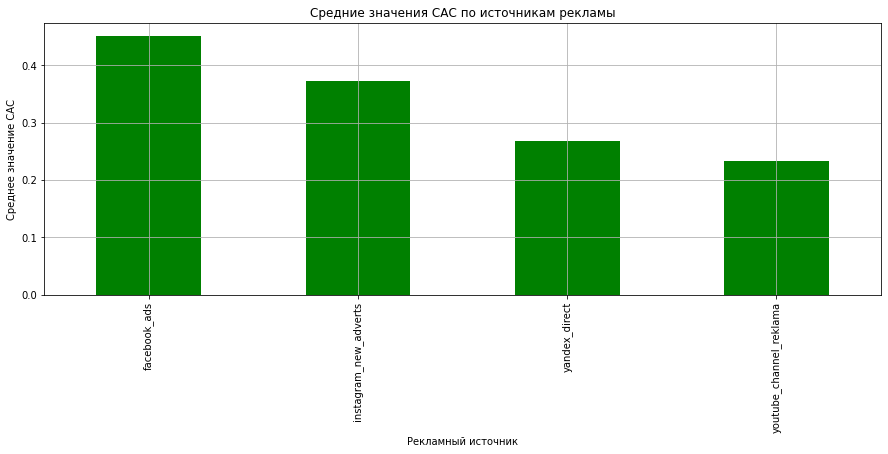

In [32]:
#рассчитаем средний САС для каждого источника

profiles.groupby('source')['cac'].mean().plot(kind='bar', figsize=(15,5), color='g', grid=True)
plt.title('Средние значения САС по источникам рекламы')
plt.xlabel('Рекламный источник')
plt.ylabel('Среднее значение САС')
plt.show()

По среднему показателю самой дешевой выглядит реклама на Youtube, самой дорогой - на Facebook. Посмотрим, сколько пользователей привлек каждый канал.

In [33]:
profiles.groupby('source')['user_id'].nunique()

source
facebook_ads               2726
instagram_new_adverts      3347
yandex_direct              4817
youtube_channel_reklama    2686
Name: user_id, dtype: int64

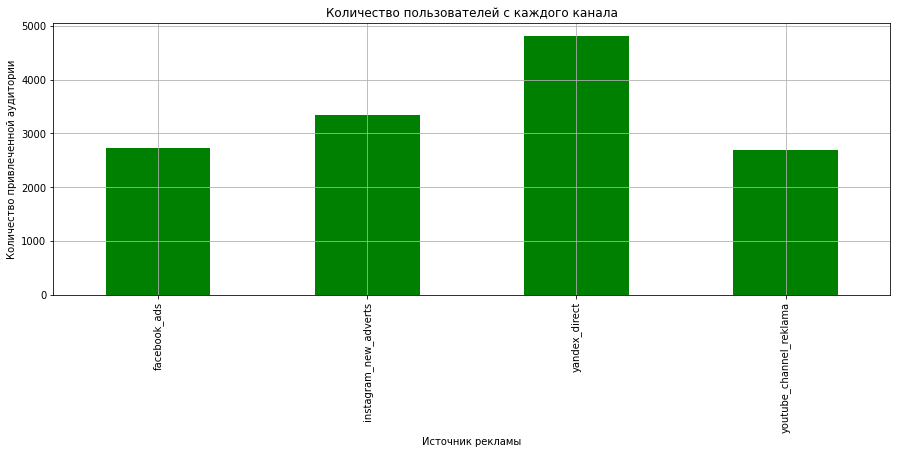

In [34]:
profiles.groupby('source')['user_id'].nunique().plot(kind='bar', figsize=(15,5), color='g', grid=True)
plt.title('Количество пользователей с каждого канала')
plt.xlabel('Источник рекламы')
plt.ylabel('Количество привлеченной аудитории')
plt.show()

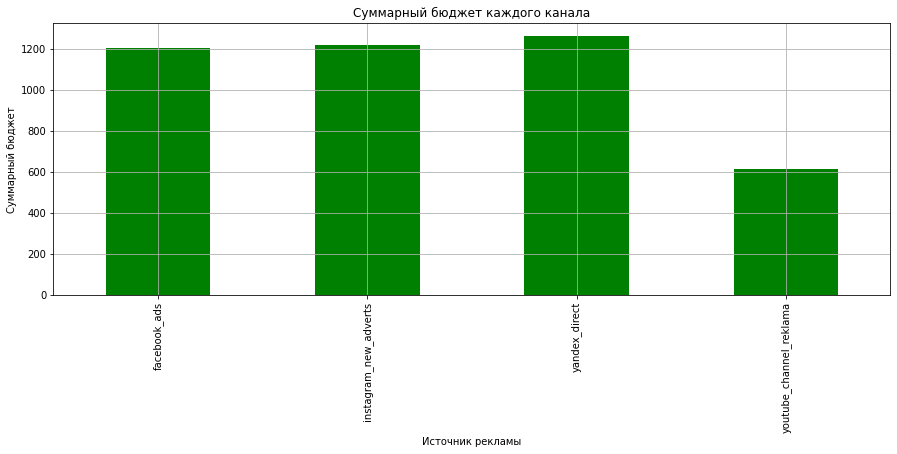

source
facebook_ads              1,205.02
instagram_new_adverts     1,218.24
yandex_direct             1,263.97
youtube_channel_reklama     613.89
Name: cost, dtype: float64

In [35]:
#посмотрим, какой бюджет суммарно потрачен на каждый канал

costs.groupby('source')['cost'].sum().plot(kind='bar', figsize=(15,5), color='g', grid=True)
plt.title('Суммарный бюджет каждого канала')
plt.xlabel('Источник рекламы')
plt.ylabel('Суммарный бюджет')
plt.show()
costs.groupby('source')['cost'].sum()

Итак, мы имеем:

1. больше всего бюджета было потрачено на Инстаграм, меньше всего - на Ютьюб.
2. больше всего пользователей пришло с Яндекса.
3. Ютьюб имеет самую низкую стоимость привлечения.
4. бюджет Ютьюб очень сильно ниже бюджета других источников.

Зафиксируем промежуточный результат и посмотрим на качество привлекаемой аудитории.

# 3.1 Анализ активности пользователей

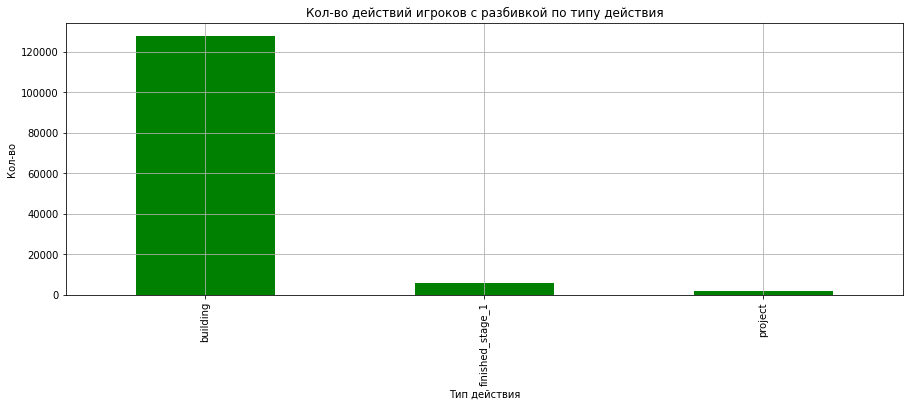

In [36]:
#посмотрим, какие действия совершали игроки в каких количествах

actions['event'].value_counts().plot(kind='bar', figsize=(15,5), grid=True, color='g')
plt.title('Кол-во действий игроков с разбивкой по типу действия')
plt.xlabel('Тип действия')
plt.ylabel('Кол-во')
plt.show()

Лидирует постройка зданий. Логично, ведь их можно строить много в ходе игры. Исследовательский проект в игре реализовало относительно небольшое число игроков.

In [37]:
#посмотрим, часто ли игроки строят здания

profiles.groupby('source')['building'].sum() / profiles['building'].sum() * 100

source
facebook_ads              20.42
instagram_new_adverts     24.86
yandex_direct             35.19
youtube_channel_reklama   19.52
Name: building, dtype: float64

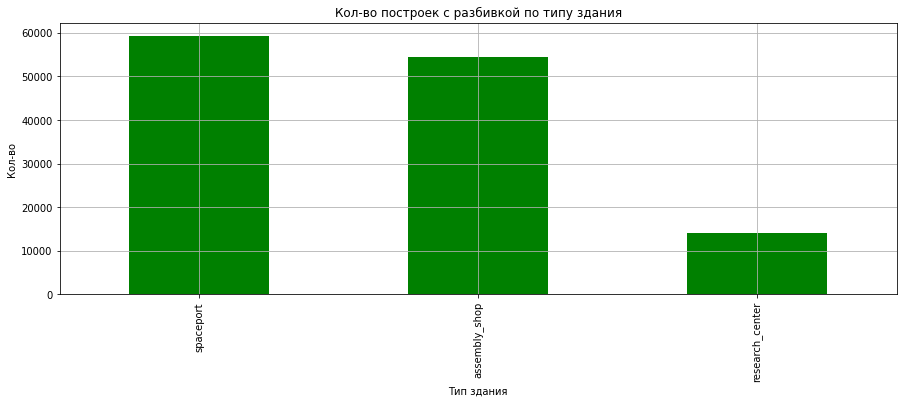

In [38]:
#посмотрим, какие здания строят чаще

actions['building_type'].value_counts().plot(kind='bar', figsize=(15,5), grid=True, color='g')
plt.title('Кол-во построек с разбивкой по типу здания')
plt.xlabel('Тип здания')
plt.ylabel('Кол-во')
plt.show()

In [39]:
#посмотрим, сколько игроков завершили 1 уровень

profiles.groupby('source')['finished_stage_1'].sum() / profiles.groupby('source')['user_id'].nunique() * 100

source
facebook_ads              42.19
instagram_new_adverts     43.80
yandex_direct             42.39
youtube_channel_reklama   43.15
dtype: float64

На следующий уровень переходит меньше половины пользователей каждого рекламного источника. Остальные либо растягивают прохождение, либо перестают играть. Среди игроков от Ютьюба и Инстаграма уровень проходит чуть больше людей. 

In [40]:
#проверим, сколько игроков завершили первый уровень через исследование

profiles.groupby('source')['satellite_orbital_assembly'].sum() / profiles.groupby('source')['user_id'].nunique() * 100

source
facebook_ads              14.34
instagram_new_adverts     14.22
yandex_direct             12.87
youtube_channel_reklama   14.11
dtype: float64

Не более 15% игроков завершили проект. Игроков с Facebook в этой категории совсем немного больше. Данное различие не повлияет на исследование. Хуже всех себя показал Яндекс.

In [41]:
#посомтрим, сколько в среднем дней проводят в игре игроки из разных источников

profiles.groupby('source')['in_game'].mean()

source
facebook_ads              10.68
instagram_new_adverts     10.75
yandex_direct             10.57
youtube_channel_reklama   10.55
Name: in_game, dtype: float64

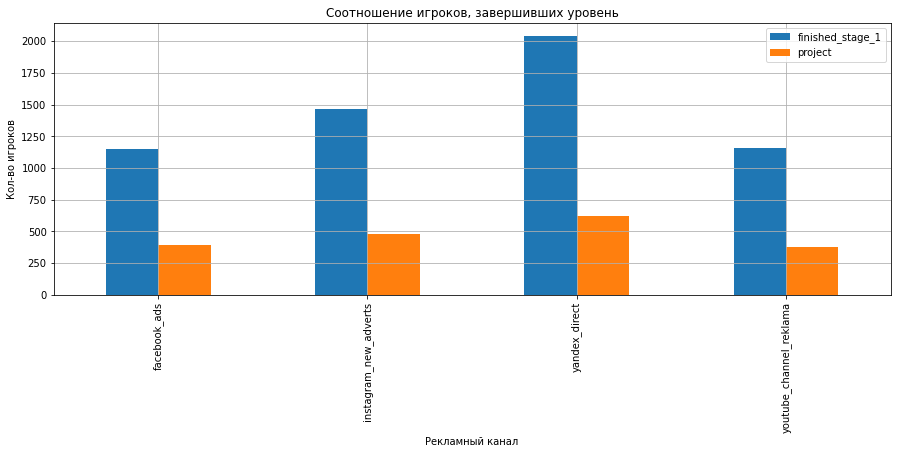

In [42]:
#построим соотношение игроков, завершивших уровень, с разбивкой по рекламным каналам

profiles.groupby('source')[['finished_stage_1', 'project']].sum().plot(kind='bar', grid=True, figsize=(15,5))
plt.title('Соотношение игроков, завершивших уровень')
plt.xlabel('Рекламный канал')
plt.ylabel('Кол-во игроков')
plt.show()

# 3.2 Вывод

Мы исследовали поведение игроков в разрезе рекламных каналов. Вот, что выяснилось:

1. менее половины привлеченных игроков завершают первый уровень;
2. менее 15% игроков предпочитают исследования, большая часть выбирает победу над другими;
3. игроки с каждого канала привлечения проводят в игре одинаковое кол-во времени - примерно 10 дней;
4. среди игровых построек игроки отдают предпочтение космопортам и сборочным цехам, а вот исследовательским центром пользуются далеко не все.

# 4.1 Статистический анализ данных

Проверим следующие гипотезы: 

1. Н0: время завершения уровня различается в зависимости от способа прохождения: через реализацию проекта или через победу над первым игроком.
Н1: время игры не зависит от способа завершения уровня.

2. Н0: объект research_center строят только игроки, выбирающие мирный стиль похождения.
Н1: строительство исследовательского центра не зависит от способа прохождения уровня.

In [43]:
#сделаем срезы игроков для исследования 1 гипотезы

project_yes = profiles.loc[(profiles['finished_stage_1'] != 0) & (profiles['project'] != 0)]

In [44]:
project_no = profiles.loc[(profiles['finished_stage_1'] != 0) & (profiles['project'] == 0)]

Наша задача - сравнить средние значения этих двух совокупностей. Для этого проведем t-тест и сравним среднее время пребывания в игре участников каждого среза. Пороговое значение зададим в 1%.

In [45]:
#записываем стобцы со временем в игре в переменные для сравнения

sample_yes = project_yes['in_game']
sample_no = project_no['in_game']

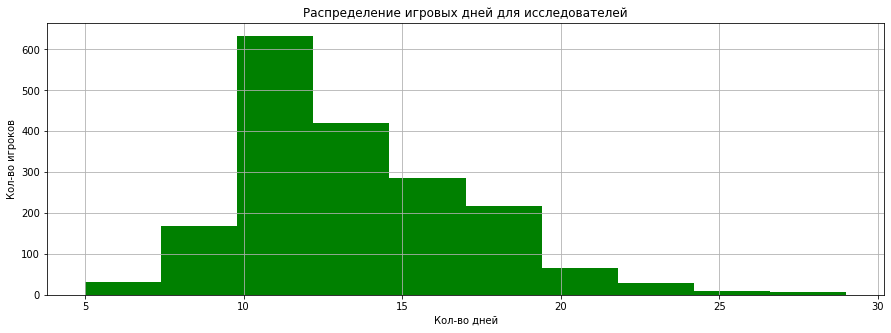

In [46]:
#посмотрим, как распределяются значения в тестовых массивах

sample_yes.hist(figsize=(15,5), color='g')
plt.title('Распределение игровых дней для исследователей')
plt.xlabel('Кол-во дней')
plt.ylabel('Кол-во игроков')
plt.show()

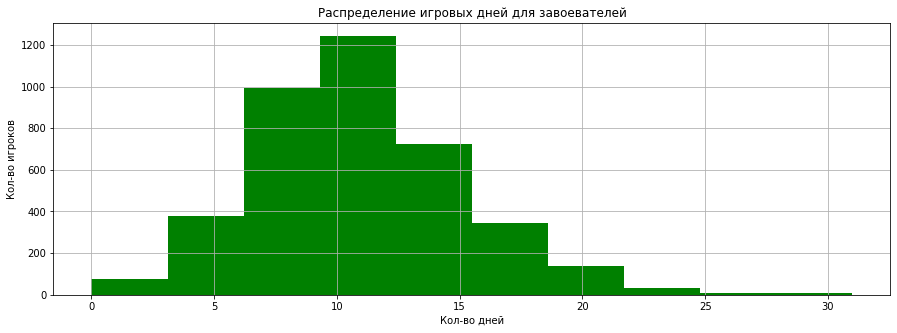

In [47]:
sample_no.hist(figsize=(15,5), color='g')
plt.title('Распределение игровых дней для завоевателей')
plt.xlabel('Кол-во дней')
plt.ylabel('Кол-во игроков')
plt.show()

Распределения обеих совокупностей близки к нормальным со сдвигом в сторону 30 дней. Можем проводить тест.

In [48]:
#проводим тест

alpha = .01

result = st.ttest_ind(sample_yes, sample_no, equal_var=False)
result

Ttest_indResult(statistic=22.379862667936557, pvalue=6.570466755643636e-105)

P-value сильно меньше предельного значения, значит мы можем отвергнуть нулевую гипотезу: среднее время игры не зависит от стиля прохождения. Исследуем вторую гипотезу.

In [49]:
#делаем срезы данных

sample_1 = project_yes['research_center']
sample_2 = project_no['research_center']

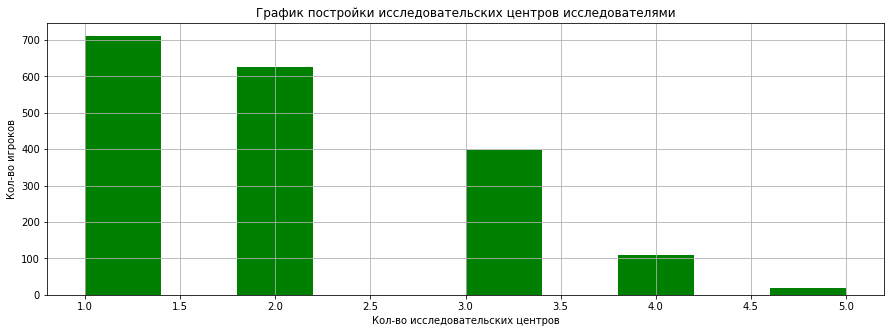

In [50]:
#визуализируем распределения

sample_1.hist(figsize=(15,5), color='g')
plt.title('График постройки исследовательских центров исследователями')
plt.xlabel('Кол-во исследовательских центров')
plt.ylabel('Кол-во игроков')
plt.show()

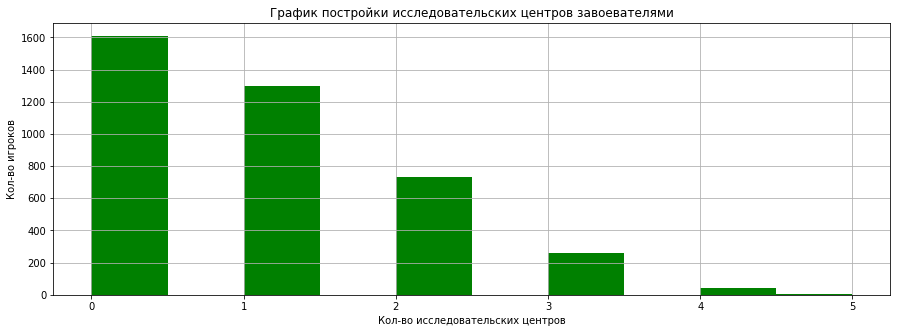

In [51]:
sample_2.hist(figsize=(15,5), color='g')
plt.title('График постройки исследовательских центров завоевателями')
plt.xlabel('Кол-во исследовательских центров')
plt.ylabel('Кол-во игроков')
plt.show()

Совокупности имеют похожий тип распределения. Можем проводить тест.

In [52]:
#проводим тест

result = st.ttest_ind(sample_1, sample_2, equal_var=False)
result

Ttest_indResult(statistic=37.81897545307505, pvalue=1.429625689403116e-265)

Полученное Р-значение сильно ниже порога статистической значимости, значит строительство иследовательских центров не сильно привязано к стилю прохождения, игроков останавливает что-то другое.

# Общий вывод 

Мы исследовали игровые логи за месяц и данные о закупленной рекламе. На основании полученного результата можно сделать следующие выводы о рентабельности рекламных источников:

1. самый дорогой канал по затратам на пользователя - Facebook, самый дешевый - Youtube;
2. Ютьюб имеет самую низкую стоимость привлечения, при этом его рекламный бюджет значительно ниже бюджета других тсточников;
3. игроки с каждого канала проводят в игре в среднем по 10 дней, далее - переходят на второй уровень или отваливаются;
4. выбранная стратегия не влияет на скорость прохождения уровня. 

Рекомендации по выбору рекламного канала: 

Youtube хорошо себя показал: он стоит дешево, а аудиторию по количеству привлекает такую же, как дорогой Facebook